# MPASE Example Notebook

This notebook demonstrates how to run **MPASE (Multi-Point Alignment and Shape Extraction)** on simple synthetic 3D point sets and how to:
- run the pipeline (`mpase.run`)
- visualize projections and silhouettes
- export outputs for web visualization (`export_all`)

In [1]:
import numpy as np
import mpase

print("mpase version:", mpase.__version__)


mpase version: 0.1.1


## 1) Generate an S-shape and a reverse S-shape (3D point clouds)

We generate two synthetic 3D S-shaped point clouds with mirrored geometry. One point set is additionally rotated and shifted to mimic arbitrary orientation before alignment.


In [2]:
def make_s_curve(
    n=4000,
    thickness=0.05,
    mirror=False,
    seed=0,
):
    rng = np.random.default_rng(seed)
    t = np.linspace(-1.0, 1.0, n, dtype=np.float32)

    # S-shaped centerline in XY
    x = t
    y = 0.65 * np.sin(np.pi * t)

    # Structured Z variation (gives true 3D shape)
    z = 0.25 * np.cos(np.pi * t)

    # Reverse S in 3D
    if mirror:
        y = -y
        z = -z

    # Add thickness (small noise around the curve)
    x = x + thickness * rng.normal(size=n).astype(np.float32)
    y = y + thickness * rng.normal(size=n).astype(np.float32)
    z = z + 0.02 * rng.normal(size=n).astype(np.float32)

    return np.stack([x, y, z], axis=1).astype(np.float32)


# Generate point sets
A  = make_s_curve(n=5000, mirror=False, seed=1)
B0 = make_s_curve(n=5000, mirror=True,  seed=2)

# Apply rotation + shift to B (arbitrary orientation)
theta = np.deg2rad(35.0).astype(np.float32)

Rz = np.array([[np.cos(theta), -np.sin(theta), 0],
               [np.sin(theta),  np.cos(theta), 0],
               [0,              0,             1]], dtype=np.float32)

Ry = np.array([[ np.cos(theta), 0, np.sin(theta)],
               [ 0,             1, 0],
               [-np.sin(theta), 0, np.cos(theta)]], dtype=np.float32)

R = (Rz @ Ry).astype(np.float32)

B = (B0 @ R.T) + np.array([0.35, -0.10, 0.12], dtype=np.float32)

labels = ["S", "reverse-S"]

## 2) BEFORE alignment: 2D projections of the raw inputs

This view shows why alignment matters. The two point sets differ in shape (S vs reverse-S) and B is also rotated/shifted.


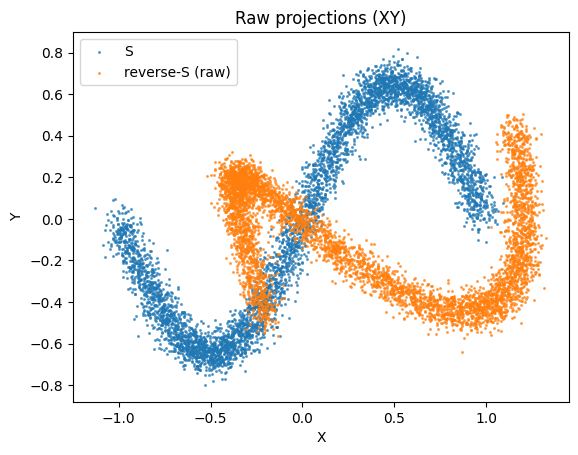

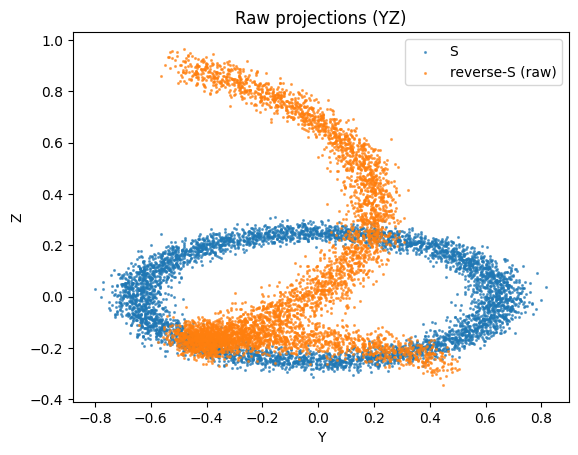

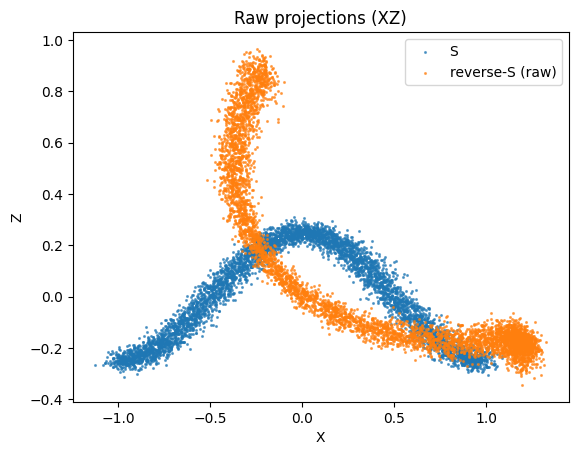

In [3]:
import matplotlib.pyplot as plt

def plot_projections_raw(A, B, planes=("XY","YZ","XZ"), s=1.5, alphaA=0.6, alphaB=0.6):
    for plane in planes:
        if plane == "XY":
            a1, a2 = A[:,0], A[:,1]
            b1, b2 = B[:,0], B[:,1]
            xlabel, ylabel = "X", "Y"
        elif plane == "YZ":
            a1, a2 = A[:,1], A[:,2]
            b1, b2 = B[:,1], B[:,2]
            xlabel, ylabel = "Y", "Z"
        else:  # XZ
            a1, a2 = A[:,0], A[:,2]
            b1, b2 = B[:,0], B[:,2]
            xlabel, ylabel = "X", "Z"

        plt.figure()
        plt.scatter(a1, a2, s=s, alpha=alphaA, label="S")
        plt.scatter(b1, b2, s=s, alpha=alphaB, label="reverse-S (raw)")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(f"Raw projections ({plane})")
        plt.legend()
        plt.show()

plot_projections_raw(A, B, planes=("XY","YZ","XZ"))


## 3) Run MPASE (HDR + Point-Fraction)

`align_mode="auto"` aligns all sets to the first label (here: `S`).

We write outputs to `out_dir` so you can inspect saved files.


In [4]:
cfg_common = mpase.CfgCommon(
    grid_base=200,
    pad_frac=0.06,
    icp_iters=35,
    trim_q=0.10,
    sample_icp=50000,
)

cfg_hdr = mpase.CfgHDR(
    n_boot=128,
    sigma_px=1.6,             # a bit smoother to avoid speckles
    density_floor_frac=0.003, # small floor to drop tiny islands
    mass_levels=(1.00, 0.80),
    rng_seed=0,
)

cfg_pf = mpase.CfgPF(
    frac_levels=(1.00, 0.80),
    bandwidth=None,
    disk_px=3,  # helps reduce pixel speckles
    morph=mpase.CfgMorph(closing=2, opening=2, keep_largest=True, fill_holes=True),
)

res = mpase.run(
    points_list=[A, B],
    labels=labels,
    align_mode="auto",
    run_hdr=True,
    run_pf=True,
    planes=("XY", "YZ", "XZ"),
    out_dir="mpase_scurve_out",
    cfg_common=cfg_common,
    cfg_hdr=cfg_hdr,
    cfg_pf=cfg_pf,
)

sorted(res.keys())


['aligned_points',
 'background',
 'background_by_label',
 'densities',
 'ids_by_label',
 'labels',
 'meta',
 'metrics',
 'projections',
 'shapes']

## 4) AFTER alignment: 2D projections of the aligned outputs

This view uses MPASE's stored aligned points to show the shared reference frame.


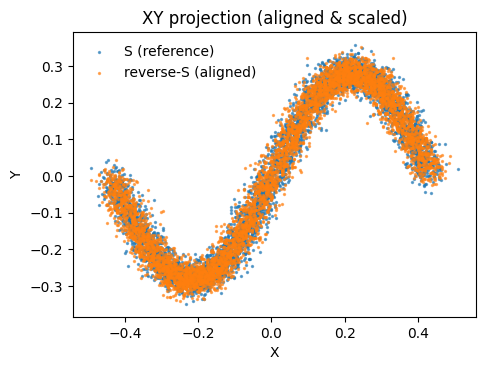

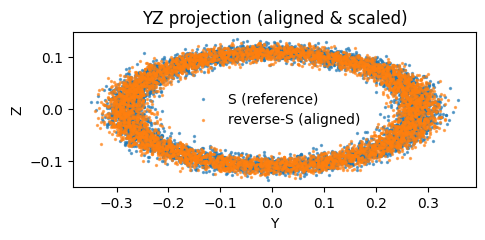

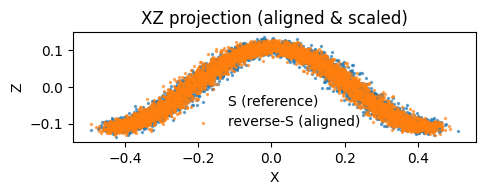

In [5]:
mpase.view_projections(
    res,
    planes=("XY","YZ","XZ"),
    A_lab="S",
    B_lab="reverse-S",
    labelA="S (reference)",
    labelB="reverse-S (aligned)",
    s=2.0,
    alphaA=0.6,
    alphaB=0.6,
)


## 5) Inspect metrics

Metrics are computed pairwise across labels and reported per plane/method/level.


In [6]:
metrics = res["metrics"]
metrics.head(12)


,mode,plane,level,A,B,IoU,meanNN,Hausdorff
4,hdr,XY,100,S,reverse-S,0.856905,1.561390,5.186574
5,hdr,XY,80,S,reverse-S,0.863530,0.749467,2.945863
10,point_fraction,XY,100,S,reverse-S,0.849348,1.558277,5.830952
11,point_fraction,XY,80,S,reverse-S,0.883350,1.130667,5.656854
2,hdr,XZ,100,S,reverse-S,0.912421,0.735421,2.741212
3,hdr,XZ,80,S,reverse-S,0.922566,0.341469,2.255044
8,point_fraction,XZ,100,S,reverse-S,0.872517,0.987543,4.123106
9,point_fraction,XZ,80,S,reverse-S,0.877685,0.981739,4.123106
0,hdr,YZ,100,S,reverse-S,0.917987,0.785311,5.608703
1,hdr,YZ,80,S,reverse-S,0.909747,0.363950,1.345790


## 6) Visualize silhouettes (overlay)

- `kind="hdr"` shows HDR silhouettes (optionally with heatmap underlay)
- `kind="point_fraction"` shows point-fraction silhouettes


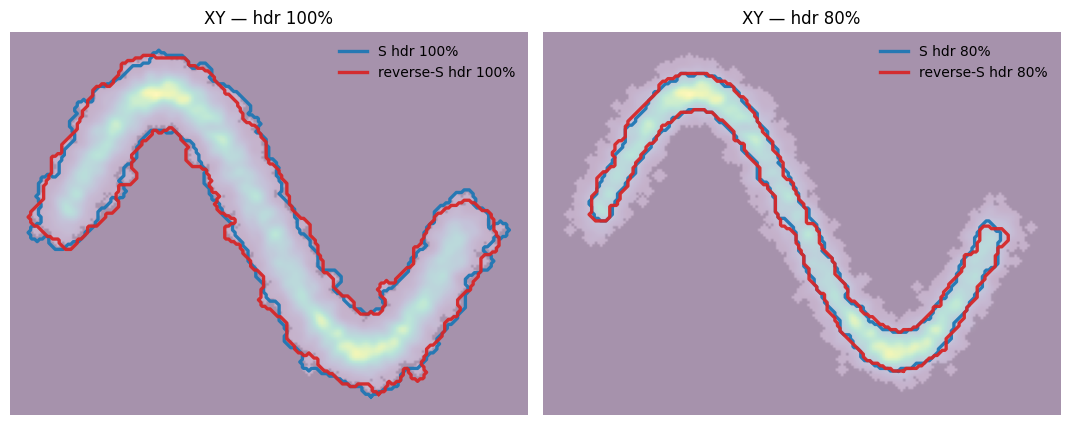

In [7]:
mpase.view(
    res,
    kind="hdr",
    plane="XY",
    levels=[100, 80],
    A_lab="S",
    B_lab="reverse-S",
    labelA="S",
    labelB="reverse-S",
    show_heat=True,
    clean_blobs=True,
    blob_min_len=25,
    blob_min_area_frac=0.01,
)


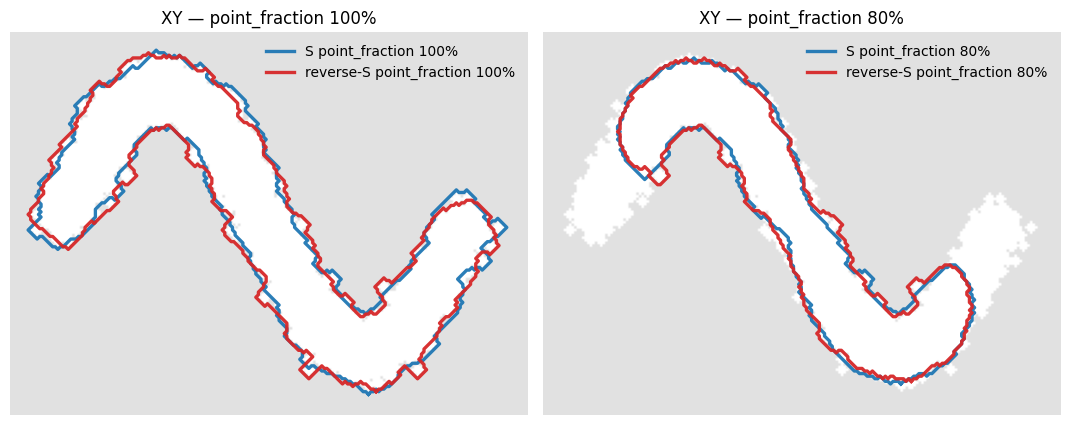

In [8]:
mpase.view(
    res,
    kind="point_fraction",
    plane="XY",
    levels=[100, 80],
    A_lab="S",
    B_lab="reverse-S",
    labelA="S",
    labelB="reverse-S",
    show_heat=False,
    clean_blobs=True,
    blob_min_len=25,
    blob_min_area_frac=0.01,
)


## 7) Single-label view

Use this when you do not want an overlay (inspect one condition at a time).


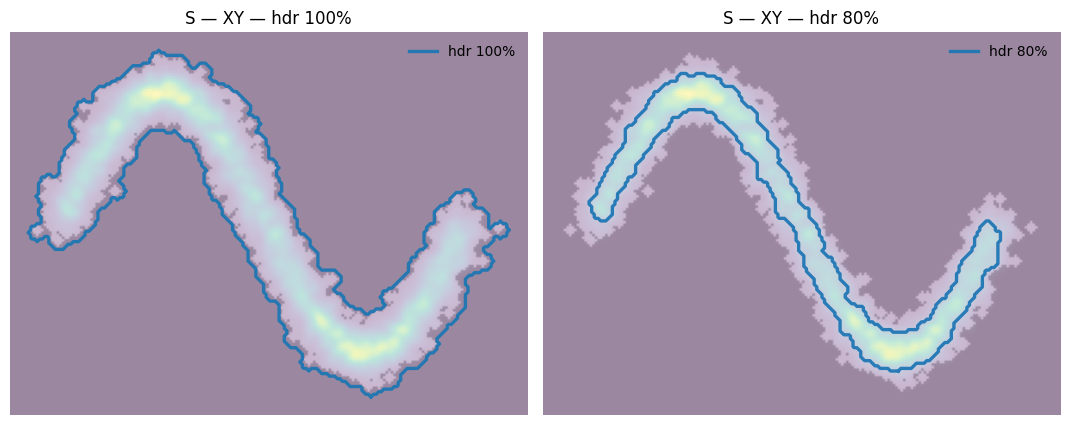

In [9]:
mpase.view_single(
    res,
    label="S",
    kind="hdr",
    plane="XY",
    levels=[100, 80],
    show_heat=True,
    clean_blobs=True,
    blob_min_len=25,
    blob_min_area_frac=0.01,
)


## 8) Save figures to disk


In [10]:
mpase.save_figures(
    res,
    kind="hdr",
    plane="XY",
    levels=[100, 80],
    A_lab="S",
    B_lab="reverse-S",
    labelA="S",
    labelB="reverse-S",
    show_heat=True,
    out_dir="figures",
    clean_blobs=True,
    blob_min_len=25,
    blob_min_area_frac=0.01,
)


In [11]:
mpase.save_per_label(
    res,
    labels=["S","reverse-S"],
    kind="point_fraction",
    plane="XY",
    levels=[100, 80],
    out_dir="figures_single",
    show_heat=False,
    dpi=220,
    clean_blobs=True,
    blob_min_len=25,
    blob_min_area_frac=0.01,
)


## 9) Export outputs for web visualization


In [12]:
mpase.export_all(
    res,
    out_dir="mpase_data",
    include_density=True,
    kind_levels={"hdr": [100, 80], "point_fraction": [100, 80]},
    export_layout=True,
    export_scales=True,
    clean_blobs=True,
    blob_min_len=25,
    blob_min_area_frac=0.01,
)
